Here, I tested alpha #6 published by Kakushadze at https://arxiv.org/pdf/1601.00991.pdf.

In [1]:
from zipline.api import (
    attach_pipeline,
    date_rules,
    order_target_percent,
    pipeline_output,
    record,
    schedule_function,
)
from zipline.finance import commission, slippage
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import CustomFactor
from zipline.pipeline.data import EquityPricing

from zipline import run_algorithm
import pandas as pd
import numpy as np
import pandas_datareader.data as web

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, module="numpy")

STARTING_CASH = 1e5

class Alpha6(CustomFactor):
    """
    **Default Inputs**: :data:`zipline.pipeline.data.EquityPricing.open and volume`

    **Default Window Length**: 10
    """

    window_length = 10
    inputs = (EquityPricing.open,EquityPricing.volume,)
    window_safe = True
    
    def compute(self, today, assets, out, opens, volumes):
        n_of_assets = opens.shape[1]
        corr_coef = np.corrcoef(opens, volumes, rowvar=False)
        corr_coef = corr_coef[n_of_assets:,0:n_of_assets]
        out[:] = -corr_coef.diagonal()

class MinOfPriceMultiVol(CustomFactor):
    """
    In essence, I created this Factor/Filter to avoid buying stocks that the market was uninterested in,
    ie, those trading with low volumns. Such low liquidity would cause problems. 
    """
    
    window_length = 10
    inputs = (EquityPricing.close,EquityPricing.volume,)
    window_safe = True
    
    def compute(self, today, assets, out, closes, volumes):
        out[:] = np.nanmin(closes*volumes, axis=0)

def make_pipeline():
    alpha6 = Alpha6()
    return Pipeline(
        columns={
            "longs": alpha6.top(10),
        },
        screen=MinOfPriceMultiVol() > STARTING_CASH * 1000,
    )


def rebalance(context, data):
    pipeline_data = context.pipeline_data
    
    all_assets = pipeline_data.index

    longs = all_assets[pipeline_data.longs]

    record(universe_size=len(all_assets))

    for asset in longs:
        order_target_percent(asset, 1.0/20.0) # 1/2 portfolio for long, 1/2 portfolio in cash

    portfolio_assets = longs
    
    positions = context.portfolio.positions
    
    # see all other stocks that were longed
    for asset in positions.keys() - set(portfolio_assets):
        # This will fail if the asset was removed from our portfolio because it
        # was delisted.
        if data.can_trade(asset):
            order_target_percent(asset, 0)


def initialize(context):
    attach_pipeline(make_pipeline(), "my_pipeline")

    # Rebalance each day.  In daily mode, this is equivalent to putting
    # `rebalance` in our handle_data, but in minute mode, it's equivalent to
    # running at the start of the day each day.
    schedule_function(rebalance, date_rules.every_day())

    # assume commission scales with the tollar dollar transacted
    context.set_commission(commission.PerDollar(cost=3e-4))
    # assume price executed is a quadratic function of volume share
    # because the volume share is usually minimal, slippage is almost nothing
    context.set_slippage(slippage.VolumeShareSlippage())
    
def before_trading_start(context, data):
    
    context.pipeline_data = pipeline_output("my_pipeline")


start = pd.Timestamp('2017-01-01')
end = pd.Timestamp('2017-12-30')

sp500 = web.DataReader('SP500', 'fred', start, end).SP500
benchmark_returns = sp500.ffill().pct_change()

result = run_algorithm(start=start,#.tz_localize('UTC')
                       end=end,#.tz_localize('UTC')
                       initialize=initialize,
                       before_trading_start=before_trading_start,
                       capital_base=STARTING_CASH,
                       benchmark_returns=benchmark_returns,
                       bundle='quandl',
                       data_frequency='daily')

/var/folders/h0/0qvqyxfx4rv03h7hnykyft2r0000gp/T/ipykernel_30771/3973608703.py:54: RuntimeWarning: All-NaN slice encountered
  out[:] = np.nanmin(closes*volumes, axis=0)
/var/folders/h0/0qvqyxfx4rv03h7hnykyft2r0000gp/T/ipykernel_30771/3973608703.py:54: RuntimeWarning: All-NaN slice encountered
  out[:] = np.nanmin(closes*volumes, axis=0)
/var/folders/h0/0qvqyxfx4rv03h7hnykyft2r0000gp/T/ipykernel_30771/3973608703.py:54: RuntimeWarning: All-NaN slice encountered
  out[:] = np.nanmin(closes*volumes, axis=0)


Text(0, 0.5, 'SP500')

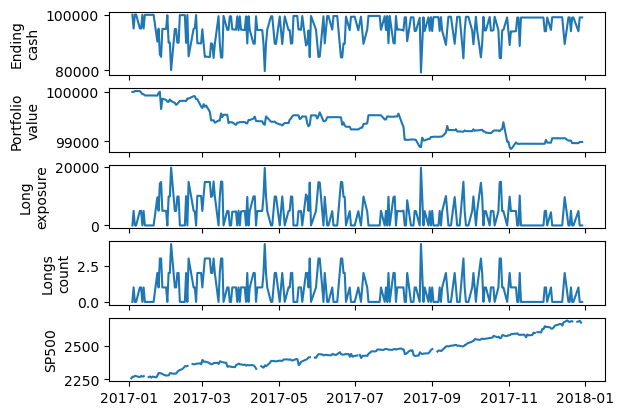

In [2]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5,1,sharex=True)
ax1.plot(result.ending_cash)
ax2.plot(result.portfolio_value)
ax3.plot(result.long_exposure)
ax4.plot(result.longs_count)
ax5.plot(sp500)
ax1.set_ylabel('Ending\ncash')
ax2.set_ylabel('Portfolio\nvalue')
ax3.set_ylabel('Long\nexposure')
ax4.set_ylabel('Longs\ncount')
ax5.set_ylabel('SP500')